In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import anndata
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
import gseapy as 

In [2]:
adata = sc.read_h5ad('data/aa_aligned_adata_sc.h5ad')

In [3]:
#Need to get raw data for differential gene expression given variable genes may be different. 
tregs = adata.raw.to_adata()

In [4]:
tregs = tregs[tregs.obs['fine_clustering']=='CD4_Treg']

In [5]:
#Subset pre & post separately
tregs_pre = tregs[tregs.obs['timepoint']=='pre']
tregs_post = tregs[tregs.obs['timepoint']=='post']

In [6]:
#Unique clono ids:
clone_ids = tregs.obs['cc_aa_alignment'].unique()
tregs_pre.obs['exp_size']= 0
tregs_post.obs['exp_size']= 0

for i in clone_ids:
    
    tregs_pre.obs.loc[(adata.obs['cc_aa_alignment']==i), 'exp_size'] = len(tregs_pre.obs[(adata.obs['cc_aa_alignment']==i)])
    tregs_post.obs.loc[(adata.obs['cc_aa_alignment']==i), 'exp_size'] = len(tregs_post.obs[(adata.obs['cc_aa_alignment']==i)])

/tmp/ipykernel_739913/2399477215.py:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  tregs_pre.obs['exp_size']= 0
/tmp/ipykernel_739913/2399477215.py:4: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  tregs_post.obs['exp_size']= 0
/tmp/ipykernel_739913/2399477215.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tregs_pre.obs.loc[(adata.obs['cc_aa_alignment']==i), 'exp_size'] = len(tregs_pre.obs[(adata.obs['cc_aa_alignment']==i)])
/tmp/ipykernel_739913/2399477215.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tregs_post.obs.loc[(adata.obs['cc_aa_alignment']==i), 'exp_size'] = len(tregs_post.obs[(adata.obs['cc_aa_alignment']==i)])


Interested in the effect of IL2 has on Tregs - therefore use post treatment timepoint i.e remove saline sub group

In [7]:
#Bin Data
tregs_post.obs['exp_name'] = 'Na'

tregs_post.obs.loc[(tregs_post.obs['exp_size'] == 1), 'exp_name'] = 'non-expanded'
tregs_post.obs.loc[(tregs_post.obs['exp_size'] > 1), 'exp_name'] = 'expanded'

Interested in the effect of IL2 has on Tregs - therefore use post treatment timepoint i.e remove saline sub group

In [8]:
tregs_post = tregs_post[~tregs_post.obs['treatment'].isin(['Saline'])]
tregs_post.obs['exp_name'].value_counts()

non-expanded    1103
expanded         127
Name: exp_name, dtype: int64

In [9]:
adata = tregs_post.copy()

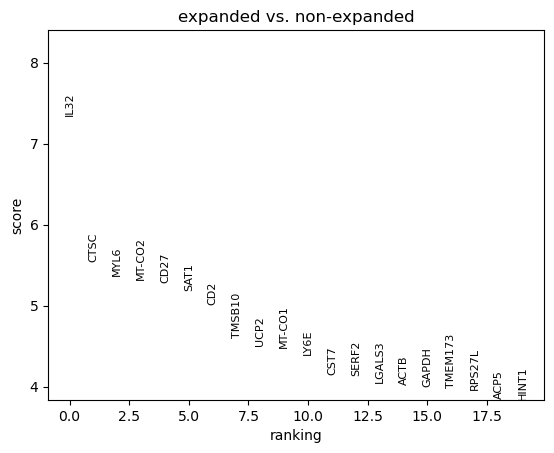

In [10]:
#Run willcoxen DEG analysis:
sc.tl.rank_genes_groups(adata, groupby='exp_name', use_raw=False, method='wilcoxon', key_added = "treg-wilcoxon", groups=['expanded'], reference='non-expanded')
sc.pl.rank_genes_groups(adata, sharey=False, key="treg-wilcoxon")

----------------------------------
# GSEA Analysis:

In [11]:
adata.obs['exp_name'].value_counts()

non-expanded    1103
expanded         127
Name: exp_name, dtype: int64

In [12]:
# set Expaned as class 0, non-expanded as class 1, to make categorical
adata.obs['exp_name2'] = pd.Categorical(adata.obs['exp_name'], categories=["expanded", "non-expanded"], ordered=True)
indices = adata.obs.sort_values(['fine_clustering', 'exp_name2']).index
adata = adata[indices,:]

In [13]:
gsea_results = gp.gsea(data=adata.to_df().T,
        gene_sets=["GO_Biological_Process_2021","MSigDB_Hallmark_2020","KEGG_2021_Human"], 
        cls=adata.obs.exp_name2,
        permutation_num=5000,
        permutation_type='phenotype',
        outdir=None,
        method='s2n',
        threads= 16)

/home/jo388/miniconda3/envs/bioinfo/lib/python3.10/site-packages/gseapy/gsea.py:116: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[df_std.abs().sum(axis=1) > 0]


In [14]:
df = gsea_results.res2d
df.sort_values('NES', inplace=True)
df.reset_index(drop=True, inplace=True)
#if FDR Q-Val is 0 then value is < 1/permeatations
df['FDR q-val'].values[df['FDR q-val']==0.0] = 0.0002
df

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,gsea,KEGG_2021_Human__Coronavirus disease,-0.693378,-2.849569,0.0,0.0002,0.0,80/158,11.72%,RPL10;RPS6;RPL13;RPL30;RPSA;RPL28;RPS27;RPS29;...
1,gsea,GO_Biological_Process_2021__peptide biosynthet...,-0.722709,-2.819931,0.0,0.0002,0.0,72/143,9.10%,RPL10;RPS6;RPL13;RPL30;RPSA;RPL28;RPS27;RPS29;...
2,gsea,GO_Biological_Process_2021__protein targeting ...,-0.807443,-2.783407,0.0,0.0002,0.0,65/102,6.54%,RPL10;RPS6;RPL13;RPL30;RPSA;RPL28;RPS27;RPS29;...
3,gsea,KEGG_2021_Human__Ribosome,-0.738426,-2.767364,0.0,0.0002,0.0,67/129,6.54%,RPL10;RPS6;RPL13;RPL30;RPSA;RPL28;RPS27;RPS29;...
4,gsea,GO_Biological_Process_2021__nuclear-transcribe...,-0.785292,-2.765196,0.0,0.0002,0.0,72/113,7.67%,RPL10;RPS6;RPL13;RPL30;RPSA;RPL28;RPS27;RPS29;...
...,...,...,...,...,...,...,...,...,...,...
2407,gsea,KEGG_2021_Human__Complement and coagulation ca...,0.536469,2.172997,0.0,0.025763,0.082,14/26,23.17%,C3AR1;ITGB2;PLAUR;CD59;C8G;C4BPB;F2RL2;ITGAX;P...
2408,gsea,GO_Biological_Process_2021__regulation of T ce...,0.588418,2.237725,0.0,0.013379,0.0344,20/37,17.34%,CD2;LGALS3;CD4;CCR2;TBX21;CCL5;SIT1;SIRPG;TNFR...
2409,gsea,GO_Biological_Process_2021__regulation of phag...,0.557362,2.271582,0.0,0.011205,0.0216,17/33,18.81%,FCER1G;IL2RG;SNX3;CALR;SIRPG;TNF;FGR;LMAN2;CYB...
2410,gsea,GO_Biological_Process_2021__negative regulatio...,0.579812,2.281176,0.000483,0.015329,0.0196,11/28,16.16%,HAVCR2;IL4;GSTP1;SLAMF1;PTPN6;CD274;ARG2;RARA;...


In [15]:
#Export all data then can filter later:
df.to_csv("expanded_treg_gsea_all_5K.csv")

## Expaned v Non-Expanded Treg Heatmaps:

In [16]:
TCR_signalling =[
                "ZAP70",
                "MKI67",
                "IKZF2",
                "TNFRSF9", 
                "ITGAE",]

Treg_function=[
                'CTLA4',
                'ICOS',
                'LAG3',
                'TIGIT',
                'TNFRSF18',
                'FOXP3',
                'IL2RA',
                'IKZF2',
                'TNFRSF4',]

eTreg = ['TNFRSF9','RELA','RELB','IKZF2','PDCD1','ICOS','CXCR3']



cmTreg = ['TCF7','BCL2','SELL','S1PR1', "CCR7"]

In [17]:
volcanodf = sc.get.rank_genes_groups_df(adata, group='expanded', key='treg-wilcoxon')

volcanodf['nlog10'] = -np.log10(volcanodf.pvals_adj)


In [18]:
lfc = volcanodf[['names','logfoldchanges']]
lfc.set_index('names',inplace=True)


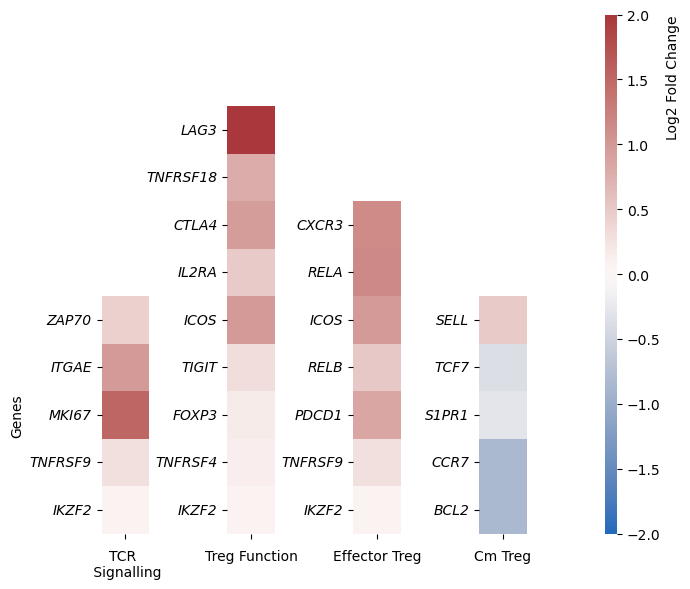

In [19]:
fig, (ax1, ax2, ax3, ax4, cax) = plt.subplots(ncols=5, sharey=False, figsize=(7,6), 
                                    gridspec_kw={"width_ratios":[1,1,1,1,0.25]})
fig.subplots_adjust(wspace=0.6)

ax1 = sns.heatmap(data=lfc
            [lfc.index.isin(TCR_signalling)],cmap='vlag', vmin=-2, vmax=2, ax=ax1, cbar_ax=cax, square=True)

ax2 = sns.heatmap(data=lfc
            [lfc.index.isin(Treg_function)],cmap='vlag', vmin=-2, vmax=2, ax=ax2, cbar_ax=cax, square=True)

ax3 = sns.heatmap(data=lfc
            [lfc.index.isin(eTreg)],cmap='vlag', vmin=-2, vmax=2, ax=ax3, cbar_ax=cax, square=True)

ax4 = sns.heatmap(data=lfc
            [lfc.index.isin(cmTreg)],cmap='vlag', vmin=-2, vmax=2, ax=ax4, cbar_ax=cax, square=True)

ax1.set_ylabel("Genes")
ax2.set_ylabel("")
ax3.set_ylabel("")
ax4.set_ylabel("")

ax1.set_xlabel('TCR \n Signalling')
ax1.set_xticklabels('')
ax2.set_xlabel('Treg Function')
ax2.set_xticklabels("")
ax3.set_xlabel('Effector Treg')
ax3.set_xticklabels("")
ax4.set_xlabel('Cm Treg')
ax4.set_xticklabels("")

ax1.set_yticklabels(ax1.get_yticklabels(),fontdict={'fontstyle':'italic'})
ax2.set_yticklabels(ax2.get_yticklabels(),fontdict={'fontstyle':'italic'})
ax3.set_yticklabels(ax3.get_yticklabels(),fontdict={'fontstyle':'italic'})
ax4.set_yticklabels(ax4.get_yticklabels(),fontdict={'fontstyle':'italic'})

cax.set_ylabel('Log2 Fold Change', loc='top')
ax1.yaxis.set_tick_params(rotation=0)
ax2.yaxis.set_tick_params(rotation=0)
ax3.yaxis.set_tick_params(rotation=0)
ax4.yaxis.set_tick_params(rotation=0)

ax1.xaxis.set_tick_params(rotation=90)

ax1.set_anchor('S')
ax2.set_anchor('S')
ax3.set_anchor('S')
ax4.set_anchor('S')


plt.tight_layout()

plt.savefig("Treg Heatmap.svg", dpi=300 )
